<a href="https://colab.research.google.com/github/Slamtos26/PortfolioProjects/blob/main/AIA_PROJECT_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Convolutional Neural Networks

In this exercise, we demonstrate how to classify remotely sensed images into 21 different land use classes, assigining a single label for each image. The dataset used for this exercise is the [UC Merced Land Use dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html)&mdash;containing 100 images of size 256$\times$256 pixels for each of the 21 classes [1]. The image patches were manually extracted from the USGS National Map Urban Area Imagery collection of images for various urban areas of the United States. The images have a spatial resolution of one foot.

The code in this notebook can be run by clicking the cell containing the code block and pressing SHIFT+ENTER.

### Importing Libraries

We first import necessary libraries and functions that we are gonna use for the exercise.

In [1]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as kutils
import sklearn.ensemble
import sklearn.metrics
import skimage.feature
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import os
from tqdm import tqdm


In [3]:
from tensorflow.keras.utils import to_categorical
y_val_one_hot = to_categorical(y_val, num_classes=4)


NameError: ignored

### Reading the images

We then read the images from the data directory into numpy arrays. For each class, we take `VALIDATION_COUNT` samples for validation and the rest&mdash;for training.

In [4]:
VALIDATION_COUNT = 30

First, we initialize the random number generator with a predefined seed to make our results reproducible.

In [5]:
SEED = 42
np.random.seed(SEED)

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")
ROOT_DIR = os.path.join("gdrive", "My Drive", "AIA_Exercises", "Apple_training_data")

Mounted at /content/gdrive


In [7]:
IMAGES_DIR = os.path.join(ROOT_DIR, "dataset", "images")
CLASS_NAMES = sorted(os.listdir(IMAGES_DIR))
CLASSES_COUNT = len(CLASS_NAMES)
HEIGHT, WIDTH, DEPTH = 256, 256, 3

In [8]:
x_train, y_train, x_val, y_val = [], [], [], []

for label, class_name in enumerate(CLASS_NAMES): # loop over all classes
    class_dir = os.path.join(IMAGES_DIR, class_name)
    filenames = os.listdir(class_dir)
    np.random.shuffle(filenames)

    images, labels = [], []
    for filename in filenames: # loop over all images of class
        image_path = os.path.join(class_dir, filename)
        image = cv2.imread(image_path).astype(np.float32)[:, :, ::-1] # read image
        image /= 255 # rescale brightness to [0; 1]

        # some images in dataset have slightly different sizes, resize them
        if image.shape[0] != HEIGHT or image.shape[1] != WIDTH:
            image = cv2.resize(image, (HEIGHT, WIDTH))

        images.append(image)
        labels.append([label])

    x_train.extend(images[VALIDATION_COUNT:])
    y_train.extend(labels[VALIDATION_COUNT:])
    x_val.extend(images[:VALIDATION_COUNT])
    y_val.extend(labels[:VALIDATION_COUNT])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

# change label to one-hot: [0] -> [1 0 0 0], [1] -> [0 1 0 0], so on
y_train = kutils.to_categorical(y_train, CLASSES_COUNT)
y_val = kutils.to_categorical(y_val, CLASSES_COUNT)

<h3>Question 1:</h3>
<br>
How many dimensions do the input and target arrays have? How does categorical encoding change the dimensions?

<h3>Question 2:</h3>
<br>
What are min and max values of the input arrays? How is it different from the way they are stored on the disk?

### Model definition

Training deep networks takes a lot of time even especially when using the CPU for all the computations. We therefore train a small sample network for a small number of epochs in this exercise. If you have more time for the exercise, you can play with the training hyperparameters, e.g. training the sample network for longer epochs.

There are two common ways to define your model in `tensorflow.keras`&mdash;sequential and functional. If you use sequential interface, you define your model as a stack of layers.

In [9]:
def get_model(input_shape, classes_count):
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes_count, activation="softmax"))
    return model

In [10]:
model = get_model((HEIGHT, WIDTH, DEPTH), CLASSES_COUNT)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 flatten (Flatten)           (None, 123008)            0

The second interface is functional, it allows defining a model in the same way you write mathematical expressions in programming languages, therefore, you do not define a stack of layers but a computational graph that represents the model. The functional interface is more flexible making it simple to define models with several inputs and outputs or several parallel branches, etc.

In [11]:
def get_model(input_shape, classes_count):
    input = layers.Input(input_shape)
    conv1 = layers.Conv2D(32, kernel_size=3, activation="relu")(input)
    pool1 = layers.MaxPooling2D(pool_size=2)(conv1)
    conv2 = layers.Conv2D(32, kernel_size=3, activation="relu")(pool1)
    pool2 = layers.MaxPooling2D(pool_size=2)(conv2)
    dropout1 = layers.Dropout(0.25)(pool2)
    flatten = layers.Flatten()(dropout1)
    dense1 = layers.Dense(128, activation="relu")(flatten)
    dropout2 = layers.Dropout(0.5)(dense1)
    output = layers.Dense(classes_count, activation="softmax")(dropout2)

    model = models.Model(inputs=input, outputs=output)
    return model

In [12]:
model = get_model((HEIGHT, WIDTH, DEPTH), CLASSES_COUNT)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 32)        0     

<h3>Question 3:</h3>
<br>
How many layers with trainable parameters does the sample network have? How are two models defined in two different ways different?

### Training the network

Once everything is prepared, model training can be initiated by calling two methods&mdash;`compile` and `fit`.

In [13]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=1e-2),
    metrics=["accuracy"]
)

In [15]:
EPOCHS = 40
BATCH_SIZE = 32

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/40
9/9 [==============================] - 1s 95ms/step - loss: 0.5001 - accuracy: 0.8571 - val_loss: 0.6763 - val_accuracy: 0.7250
Epoch 2/40
9/9 [==============================] - 1s 91ms/step - loss: 0.5995 - accuracy: 0.7821 - val_loss: 0.6591 - val_accuracy: 0.7167
Epoch 3/40
9/9 [==============================] - 1s 94ms/step - loss: 0.4601 - accuracy: 0.8536 - val_loss: 0.7756 - val_accuracy: 0.6833
Epoch 4/40
9/9 [==============================] - 1s 91ms/step - loss: 0.4413 - accuracy: 0.8571 - val_loss: 0.6500 - val_accuracy: 0.7417
Epoch 5/40
9/9 [==============================] - 1s 94ms/step - loss: 0.4230 - accuracy: 0.8643 - val_loss: 0.6345 - val_accuracy: 0.7417
Epoch 6/40
9/9 [==============================] - 1s 93ms/step - loss: 0.4121 - accuracy: 0.8571 - val_loss: 0.6373 - val_accuracy: 0.7583
Epoch 7/40
9/9 [==============================] - 1s 96ms/step - loss: 0.3666 - accuracy: 0.8750 - val_loss: 0.6528 - val_accuracy: 0.7667
Epoch 8/40
9/9 [===========

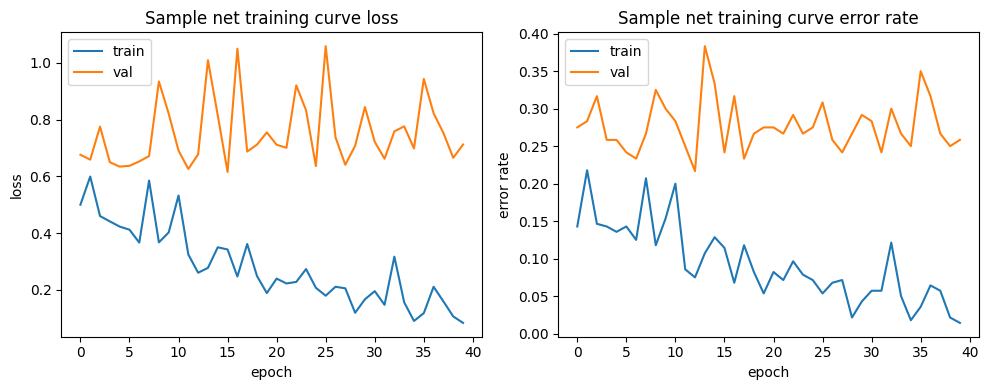

In [16]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [17]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"\nTesting accuracy of the sample network: {100 * accuracy:.2f}%")

4/4 [==============================] - 0s 21ms/step - loss: 0.7124 - accuracy: 0.7417

Testing accuracy of the sample network: 74.17%


<h3>Question 4:</h3>
<br>
Comparing the curves for training and validation, what conclusions can be made?

### Training baseline classifier
We train a random forest classifier on raw image and local binary patterns [2] features.

In [18]:
# flatten training set into row vectors
# and restore label encoding
y_train_rf = np.argmax(y_train, axis=-1)
y_val_rf = np.argmax(y_val, axis=-1)
x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_val_flatten = x_val.reshape(x_val.shape[0], -1)

# train random forest classifier
classifier = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=0
)
classifier.fit(x_train_flatten, y_train_rf)

# predict test set and print overall accuracy
predictions_rf = classifier.predict(x_val_flatten)
accuracy_rf = sklearn.metrics.accuracy_score(predictions_rf, y_val_rf)
print(f"\nTesting accuracy of RF on flatten images: {100 * accuracy_rf:.2f}%")


Testing accuracy of RF on flatten images: 74.17%


In [19]:
def extract_lbp(img_array, n_points, radius):
    """Function for extracting local binary patterns codes.
    The input array, imgarray, is a 4D image volume with
    samples along the first axis. LBP code histograms are
    computed over the whole image sample extent and for all
    bands of the image.
    """
    n_samples, n_rows, n_cols, n_bands = img_array.shape
    n_features = (n_points + 2) * n_bands
    n_features_per_band = n_features // n_bands
    img_array_lbp = np.zeros((img_array.shape[0], n_features), dtype=np.float32)

    with tqdm(total=n_samples) as pbar:
        for sample_idx in range(n_samples):
            img = img_array[sample_idx]
            img_codes = np.empty((n_rows, n_cols, n_bands), dtype="int32")
            for i in range(n_bands):
                img_codes[:, :, i] = skimage.feature.local_binary_pattern(
                    img[:, :, i], n_points, radius, method="uniform"
                )
            img_codecounts = np.zeros((n_features,), dtype=np.int32)
            for i in range(n_bands):
                img_codecounts[i*(n_features_per_band):(i+1)*(n_features_per_band)] = \
                    np.histogram(img_codes[:, :, i], bins=n_features_per_band)[0]
            img_array_lbp[sample_idx] = img_codecounts

            pbar.update(1)

    return img_array_lbp

In [20]:
# extract LBP features
N_POINTS = 12 # set number of points for LBP
RADIUS = 16 # set radius for LBP

x_train_lbp = extract_lbp(x_train, N_POINTS, RADIUS)
x_val_lbp = extract_lbp(x_val, N_POINTS, RADIUS)

# train random forest classifier
classifier = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=0
)
classifier.fit(x_train_lbp, y_train_rf)

# predict test set and print overall accuracy
predictions_rf = classifier.predict(x_val_lbp)
accuracy_rf = sklearn.metrics.accuracy_score(predictions_rf, y_val_rf)
print(f"\nTesting accuracy of RF on flatten images: {100 * accuracy_rf:.2f}%")

100%|██████████| 120/120 [00:05<00:00, 21.37it/s]



Testing accuracy of RF on flatten images: 70.00%


### Evaluating the accuracy of pre-trained networks

Finally, we evaluate the accuracy of two pre-trained deep networks based on VGG16 [3] and Inceptionv3 architecture [4]. The models are trained on the same training set with data augmentation of two flips and three 90 degree rotations applied to each of the patch and using the Adam optimizer [5].

##### VGG16

In [24]:
VGG16_PATH = os.path.join(ROOT_DIR, "pretrained", "pretrained_VGG16.hdf5")
model = models.load_model(VGG16_PATH)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import load_model

# After importing, you can use load_model to load your saved model
model = load_model(VGG16_PATH)



# Load the pre-trained VGG16 model
#model = load_model.(VGG16_PATH)
#loss, accuracy = new_model.evaluate(x_val, y_val)
# Assume that 'model' is of the 'Functional' type.

# Get the output of the last but one layer, which is before the final Dense layer with 21 units
x = model.layers[-2].output

# Create a new Dense layer with 4 units (for 4 classes) that will be added on top of the current model
new_output = Dense(4, activation='softmax')(x)

# Create the new model
new_model = Model(inputs=model.input, outputs=new_output)

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary to verify the new structure
new_model.summary()






Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

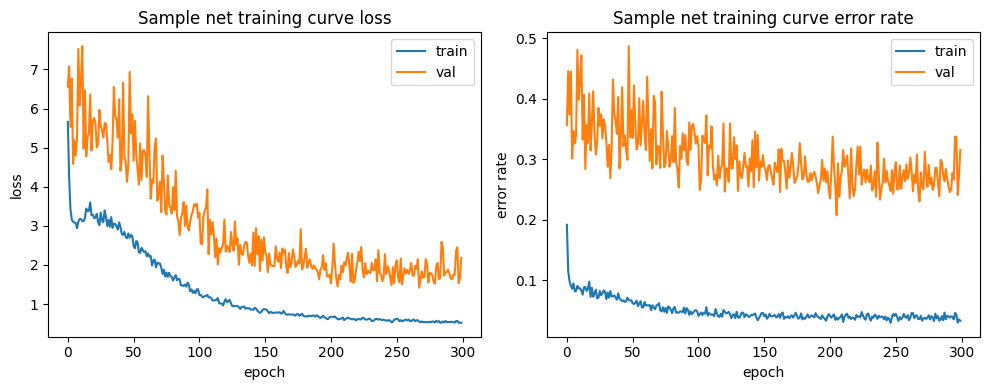

In [25]:
TRAIN_HISTORY_PATH = os.path.join(ROOT_DIR, "pretrained", "VGG16_train_history")
with open(TRAIN_HISTORY_PATH, "rb") as history_file:
    history = pickle.load(history_file)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history["loss"], label="train")
axs[0].plot(history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history["acc"]], label="train")
axs[1].plot([1 - _ for _ in history["val_acc"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [26]:
loss, accuracy = new_model.evaluate(x_val, y_val)
print(f"\nTesting accuracy of the sample network: {100 * accuracy:.2f}%")

4/4 [==============================] - 10s 1s/step - loss: 1.6400 - accuracy: 0.2500

Testing accuracy of the sample network: 25.00%


##### InceptionV3

In [27]:
INCEPTION_PATH = os.path.join(ROOT_DIR, "pretrained", "pretrained_Inception_v3.hdf5")
model = models.load_model(INCEPTION_PATH)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_400 (Conv2D)         (None, 127, 127, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_400 (B  (None, 127, 127, 32)         96        ['conv2d_400[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_399 (Activation  (None, 127, 127, 32)         0         ['batch_normalization_40

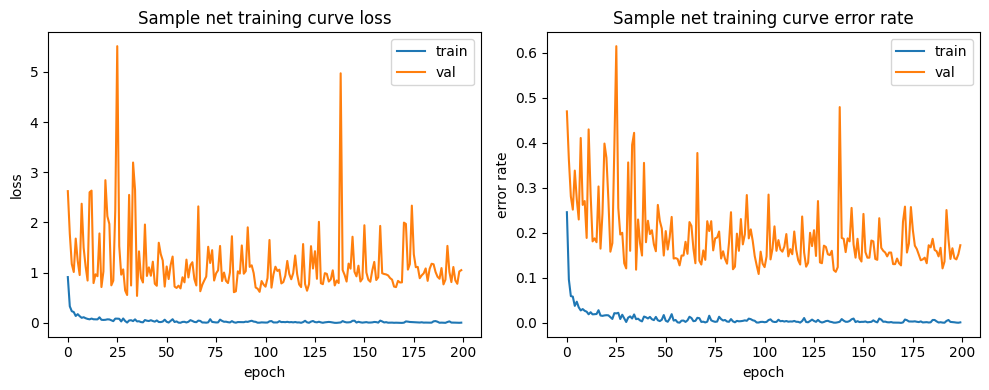

In [28]:
TRAIN_HISTORY_PATH = os.path.join(ROOT_DIR, "pretrained", "Inceptionv3_train_history")
with open(TRAIN_HISTORY_PATH, "rb") as history_file:
    history = pickle.load(history_file)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history["loss"], label="train")
axs[0].plot(history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history["acc"]], label="train")
axs[1].plot([1 - _ for _ in history["val_acc"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [29]:
loss, accuracy = new_model.evaluate(x_val, y_val)
print(f"\nTesting accuracy of the sample network: {100 * accuracy:.2f}%")

4/4 [==============================] - 1s 146ms/step - loss: 1.6400 - accuracy: 0.2500

Testing accuracy of the sample network: 25.00%


<h3>Question 5:</h3>
<br>
How do the accuracies of the three networks compare?
<h3>Question 6:</h3>
<br>
What were the necessary changes done to the architecture of the pretrained networks to be able to apply it to this land use image classification task?

4/4 [==============================] - 1s 167ms/step


<Figure size 1600x1600 with 0 Axes>

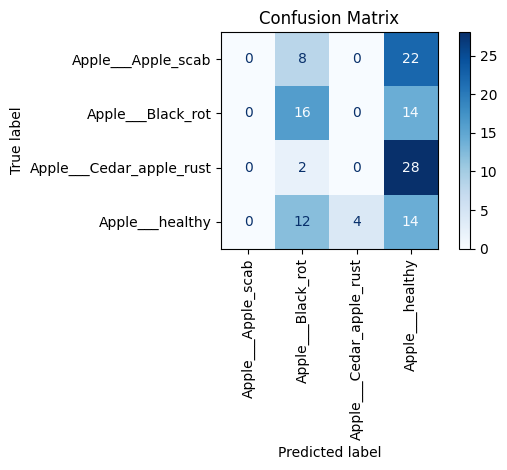

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming y_val_rf is the correct variable containing the true labels
y_val_integer = y_val_rf.copy()

# Use new_model to predict, not the old model
y_predicted = new_model.predict(x_val)
y_predicted_integer = np.argmax(y_predicted, axis=-1)

# Ensure CLASS_NAMES matches the number of unique classes in y_val_integer
unique_classes = np.unique(y_val_integer)
CLASS_NAMES = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']  # Example placeholder names
CLASS_NAMES = [CLASS_NAMES[i] for i in unique_classes]  # Filter based on unique classes

# Create the figure with the desired size BEFORE plotting the confusion matrix
plt.figure(figsize=(16, 16))

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_val_integer, y_predicted_integer,
    cmap="Blues",
    display_labels=CLASS_NAMES,
    xticks_rotation="vertical"
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()  # Show the plot


In [31]:
print(np.unique(y_val_integer))
print(np.unique(y_predicted_integer))

# Ensure that the length of CLASS_NAMES matches the number of unique classes
print(f"Number of classes in CLASS_NAMES: {len(CLASS_NAMES)}")


[0 1 2 3]
[1 2 3]
Number of classes in CLASS_NAMES: 4


<Figure size 1600x1600 with 0 Axes>

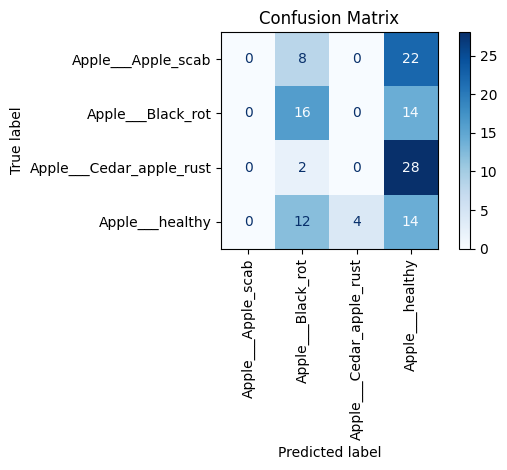

In [32]:
# Plot the confusion matrix only if the number of unique classes is correct
if len(unique_classes) == 4:
    # Create the figure with the desired size BEFORE plotting the confusion matrix
    plt.figure(figsize=(16, 16))

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_val_integer, y_predicted_integer,
        cmap="Blues",
        display_labels=CLASS_NAMES,
        xticks_rotation="vertical"
    )

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()  # Show the plot
else:
    print("The number of unique class labels does not match the expected number.")


In [33]:
print("Unique classes in y_val_rf:", np.unique(y_val_rf))

# If y_val_rf is already integer-encoded:
print("Counts for each class in y_val_rf:", np.bincount(y_val_rf))

# If y_val_rf is not integer-encoded and is categorical or one-hot encoded:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_val_integer_encoded = le.fit_transform(y_val_rf)  # This assumes y_val_rf is a flat list of class labels
print("Unique classes after encoding:", np.unique(y_val_integer_encoded))
print("Counts for each class after encoding:", np.bincount(y_val_integer_encoded))


Unique classes in y_val_rf: [0 1 2 3]
Counts for each class in y_val_rf: [30 30 30 30]
Unique classes after encoding: [0 1 2 3]
Counts for each class after encoding: [30 30 30 30]


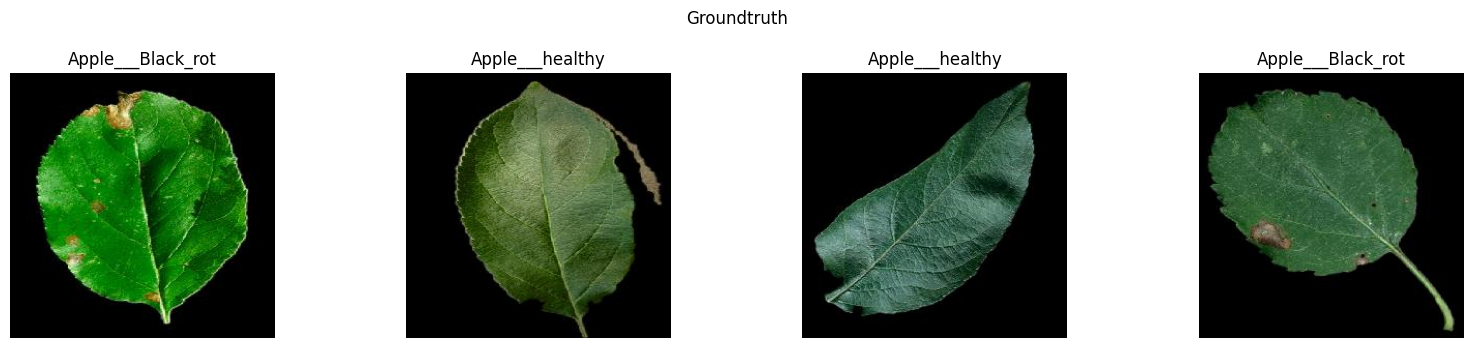

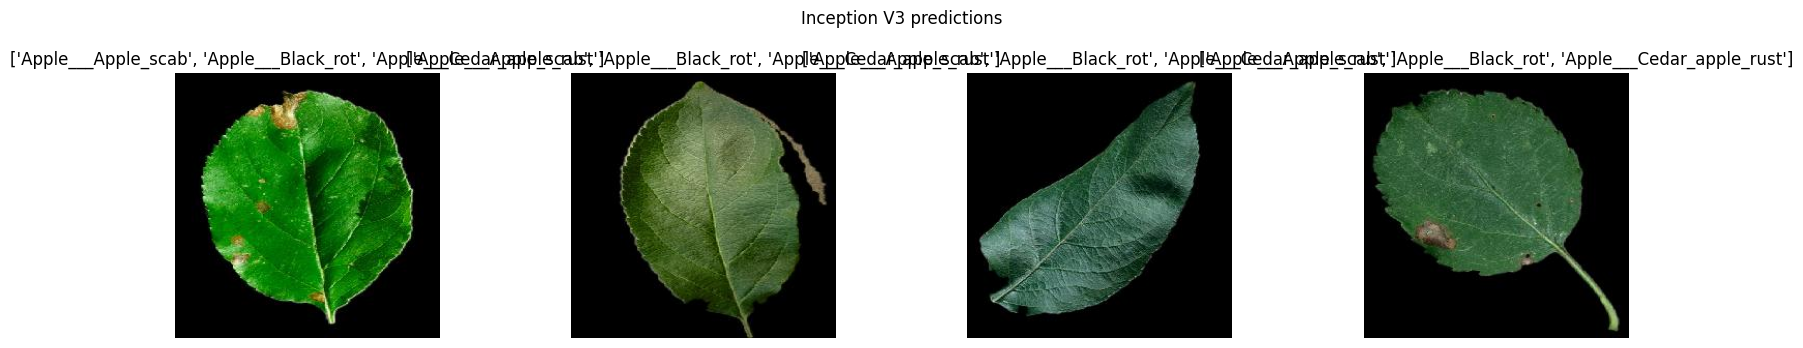

In [49]:
N_SAMPLES = 4
sample_indices = np.random.randint(x_val.shape[0], size=N_SAMPLES)

images = x_val[sample_indices]

labels = y_val_integer[sample_indices]
classes = [CLASS_NAMES[_] for _ in labels]
fig, axs = plt.subplots(nrows=1, ncols=N_SAMPLES, figsize=(16, 3.5))
plt.suptitle("Groundtruth")
for image_idx, (image, label) in enumerate(zip(images, classes)):
    axs[image_idx].imshow(image)
    axs[image_idx].set_title(label)
    axs[image_idx].axis("off")
plt.tight_layout()
plt.show()


labels = y_predicted_integer[sample_indices]
classes = [CLASS_NAMES[0:3] for _ in labels]
fig, axs = plt.subplots(nrows=1, ncols=N_SAMPLES, figsize=(16, 3.5))
plt.suptitle("Inception V3 predictions")
for image_idx, (image, label) in enumerate(zip(images, classes)):
    axs[image_idx].imshow(image)
    axs[image_idx].set_title(label)
    axs[image_idx].axis("off")
plt.tight_layout()
plt.show()

<h3>Question 7:</h3>
<br>
By running the previous cell several times, see more classification examples. Pay attention to the cases where the network gives wrong predictions. What do you think could be a reason for it?

### References

[1] Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.

[2] Ojala, T., Pietikäinen, M. and Mäenpää, T. (2002), Multiresolution Gray-scale and Rotation Invariant Texture Classification with Local Binary Patterns. IEEE Trans. Pattern Analysis and Machine Intelligence 24(7): 971-987.

[3] Simonyan, K. & Zisserman, A. (2014), 'Very Deep Convolutional Networks for Large-Scale Image Recognition', CoRR abs/1409.1556.

[4] C. Szegedy, V. Vanhoucke, S. Ioffe, J. Shlens and Z. Wojna, "Rethinking the Inception Architecture for Computer Vision," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 2818-2826.

[5] Kingma, D. P. & Ba, J. (2014), 'Adam: A Method for Stochastic Optimization.', CoRR abs/1412.6980 .